In [ ]:
from datetime import datetime
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from keras import optimizers
from keras.layers import BatchNormalization


from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd, numpy as np

from sklearn.model_selection import train_test_split
import glob, cv2, numpy as np
from tqdm import tqdm

from keras.datasets import cifar10
from matplotlib import pyplot
import zipfile
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/data

6tskin2.zip  covid.zip	neumonia2.zip  neumonia.zip


In [ ]:
!unzip /content/gdrive/MyDrive/data/neumonia2.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0439-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0440-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0441-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0442-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0444-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0445-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0446-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0447-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0448-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0449-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0450-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0451-000

In [94]:
start = datetime.now()


categorias = ['NORMAL', 'PNEUMONIA']

X = []
Y = []
X2 = []
Y2 = []
for categoria in tqdm(categorias):
  ruta_imgs = glob.glob('./chest_xray/train/'+ categoria +'/*.jpeg')
  for ruta_img in ruta_imgs:
    img = cv2.resize(cv2.cvtColor(cv2.imread(ruta_img), cv2.COLOR_RGB2BGR), (150, 150))

    '''grayScale = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1,(17,17))
    blackhat = cv2.morphologyEx(grayScale,cv2.MORPH_BLACKHAT,kernel)
    ret, threshold = cv2.threshold(blackhat, 10,255, cv2.THRESH_BINARY)
    final_image = cv2.inpaint(img,threshold, 1, cv2.INPAINT_TELEA)'''
    img_blurred = cv2.GaussianBlur(img, (5, 5), 0)  # Aplica un filtro Gaussiano 5x5

    X.append(img)
    if categoria == 'NORMAL':
      Y.append(0)
    else:
      Y.append(1)

    X2.append(img_blurred)
    if categoria == 'NORMAL':
      Y2.append(0)
    else:
      Y2.append(1)


X = np.asarray(X).astype('uint8')
Y = np.expand_dims(np.asarray(Y).astype('uint8'), axis = 1)

X2 = np.asarray(X2).astype('uint8')
Y2 = np.expand_dims(np.asarray(Y2).astype('uint8'), axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x2_train, x2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

100%|██████████| 2/2 [00:26<00:00, 13.46s/it]


In [95]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [96]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(2224, 150, 150, 3) (557, 150, 150, 3)
(2224, 1) (557, 1)


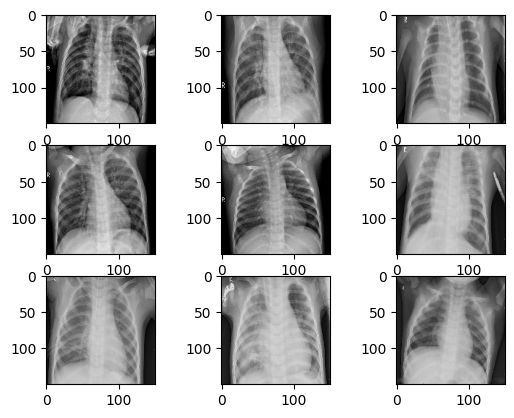

In [97]:
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(x_train[i])
pyplot.show()

In [98]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.0
x_test /= 255.0

In [99]:
y2_train = to_categorical(y2_train)
y2_test = to_categorical(y2_test)

x2_train = x2_train.astype('float32')
x2_test = x2_test.astype('float32')

x2_train /= 255.0
x2_test /= 255.0

In [100]:

model = Sequential()
model.add(Input((150, 150, 3)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
'''model.add(Dropout(0.5))
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Dropout(0.2))'''



model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation='relu'))
model.add(Dense(64, kernel_regularizer = regularizers.l2(1e-5), activation='relu'))




'''model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))'''
model.add(Flatten())
model.add(Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation='relu'))
model.add(Dense(64, kernel_regularizer = regularizers.l2(1e-5), activation='relu'))

model.add(Dense(2, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 conv2d_10 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 conv2d_11 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 128)       73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 128)       147584    
                                                      

In [101]:
learning_rate= 1e-4
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
'''loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=["accuracy"]  loss="categorical_crossentropy"  loss=tf.keras.metrics.CategoricalCrossentropy()'''

'loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=["accuracy"]  loss="categorical_crossentropy"  loss=tf.keras.metrics.CategoricalCrossentropy()'

In [102]:
print(model.output_shape)
'''y_test = to_categorical(y_test, num_classes=10)
y_test = y_test.reshape(-1, 3)'''
print(y_test.shape)

(None, 2)
(557, 2)


In [103]:
model.fit(x_train, y_train, batch_size= 128, epochs=30, verbose=1, validation_data=(x_test, y_test))

Epoch 1/30
18/18 [==============================] - 130s 7s/step - loss: 0.6978 - accuracy: 0.5076 - val_loss: 0.6965 - val_accuracy: 0.5224
Epoch 2/30
18/18 [==============================] - 128s 7s/step - loss: 0.6987 - accuracy: 0.5130 - val_loss: 0.6891 - val_accuracy: 0.4811
Epoch 3/30
18/18 [==============================] - 128s 7s/step - loss: 0.6897 - accuracy: 0.6048 - val_loss: 0.6701 - val_accuracy: 0.5242
Epoch 4/30
18/18 [==============================] - 128s 7s/step - loss: 0.8595 - accuracy: 0.7028 - val_loss: 0.6573 - val_accuracy: 0.7971
Epoch 5/30
18/18 [==============================] - 128s 7s/step - loss: 0.5244 - accuracy: 0.8233 - val_loss: 0.4193 - val_accuracy: 0.8600
Epoch 6/30
18/18 [==============================] - 128s 7s/step - loss: 0.3613 - accuracy: 0.8602 - val_loss: 0.3425 - val_accuracy: 0.8636
Epoch 7/30
18/18 [==============================] - 128s 7s/step - loss: 0.2953 - accuracy: 0.8835 - val_loss: 0.2753 - val_accuracy: 0.8725
Epoch 8/30
18

In [104]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(loss, acc)

0.1770094931125641 0.9694793820381165


In [106]:
y_pred = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

18/18 [==============================] - 4s 228ms/step


In [107]:
target_names = ['NORMAL', 'PNEUMONIA']

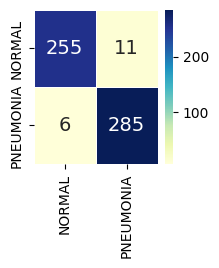

In [108]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (2,2))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [109]:
reporte = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
print(reporte)

end = datetime.now()
print( end - start)

              precision    recall  f1-score   support

      NORMAL       0.98      0.96      0.97       266
   PNEUMONIA       0.96      0.98      0.97       291

    accuracy                           0.97       557
   macro avg       0.97      0.97      0.97       557
weighted avg       0.97      0.97      0.97       557

1:05:47.589566


In [110]:
model.fit(x2_train, y2_train, batch_size= 128, epochs=30, verbose=1, validation_data=(x2_test, y2_test))

Epoch 1/30
18/18 [==============================] - 129s 7s/step - loss: 0.0865 - accuracy: 0.9672 - val_loss: 0.1031 - val_accuracy: 0.9677
Epoch 2/30
18/18 [==============================] - 129s 7s/step - loss: 0.0484 - accuracy: 0.9825 - val_loss: 0.1035 - val_accuracy: 0.9659
Epoch 3/30
18/18 [==============================] - 129s 7s/step - loss: 0.0322 - accuracy: 0.9870 - val_loss: 0.1416 - val_accuracy: 0.9695
Epoch 4/30
18/18 [==============================] - 129s 7s/step - loss: 0.0437 - accuracy: 0.9820 - val_loss: 0.1428 - val_accuracy: 0.9569
Epoch 5/30
18/18 [==============================] - 129s 7s/step - loss: 0.0244 - accuracy: 0.9906 - val_loss: 0.1201 - val_accuracy: 0.9677
Epoch 6/30
18/18 [==============================] - 129s 7s/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 0.2266 - val_accuracy: 0.9551
Epoch 7/30
18/18 [==============================] - 131s 7s/step - loss: 0.0111 - accuracy: 0.9973 - val_loss: 0.1226 - val_accuracy: 0.9677
Epoch 8/30
18

In [111]:
loss, acc = model.evaluate(x2_test, y2_test, verbose=0)
print(loss, acc)

0.23820911347866058 0.9676840305328369


In [112]:
y2_pred = model.predict(x2_test, verbose=1)
y2_pred = np.argmax(y2_pred, axis=1)

18/18 [==============================] - 4s 234ms/step


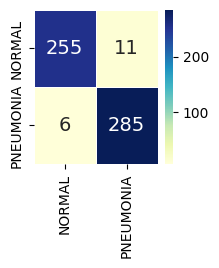

In [113]:
cm = confusion_matrix(np.argmax(y2_test, axis=1), y_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (2,2))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [114]:
reporte = classification_report(np.argmax(y2_test, axis=1), y2_pred, target_names=target_names)
print(reporte)

end = datetime.now()
print( end - start)

              precision    recall  f1-score   support

      NORMAL       0.95      0.99      0.97       266
   PNEUMONIA       0.99      0.95      0.97       291

    accuracy                           0.97       557
   macro avg       0.97      0.97      0.97       557
weighted avg       0.97      0.97      0.97       557

2:10:55.806216


#Posterior a la ejecucion del algoritmo, se almacena el modelo, para despues realizar la validacion de este proceso.

In [115]:
model.save("pneumonia.h5")
model.save_weights('pneumonia.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Se inicia un nuevo proceso

#implementando el modelo  de imagenet Xception con


In [116]:
nstar= datetime.now()
from tensorflow.keras.applications import Xception


x_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

83683744/83683744 [==============================] - 0s 0us/step


In [117]:
x_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_6[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [118]:
for layer in x_model.layers[:19]:
    layer.trainable = False


for i, layer in enumerate(x_model.layers):
    print(i, layer.name, layer.trainable)

0 input_6 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_18 False
13 block2_pool False
14 batch_normalization_3 False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_19 True
23 block3_pool True
24 batch_normalization_4 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_20 True
33 block4_pool True
34 batch_normalization_5 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepc

In [119]:
x = x_model.output
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax')(x)
x_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_6[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

In [120]:
x_custom_model = Model(inputs=x_model.input, outputs=x)
x_custom_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_6[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]'

In [121]:
learning_rate= 1e-4
x_custom_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

## SIN FILTRO

In [122]:
x_custom_model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
18/18 [==============================] - 57s 3s/step - loss: 3.8573 - accuracy: 0.8431 - val_loss: 72.4274 - val_accuracy: 0.4794
Epoch 2/20
18/18 [==============================] - 45s 3s/step - loss: 0.2033 - accuracy: 0.9487 - val_loss: 16.3954 - val_accuracy: 0.5368
Epoch 3/20
18/18 [==============================] - 45s 3s/step - loss: 0.0652 - accuracy: 0.9766 - val_loss: 6.9057 - val_accuracy: 0.6697
Epoch 4/20
18/18 [==============================] - 45s 2s/step - loss: 0.0282 - accuracy: 0.9906 - val_loss: 3.5991 - val_accuracy: 0.7056
Epoch 5/20
18/18 [==============================] - 45s 2s/step - loss: 0.0123 - accuracy: 0.9969 - val_loss: 2.8898 - val_accuracy: 0.7127
Epoch 6/20
18/18 [==============================] - 45s 2s/step - loss: 0.0263 - accuracy: 0.9901 - val_loss: 1.4044 - val_accuracy: 0.7828
Epoch 7/20
18/18 [==============================] - 44s 2s/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.8246 - val_accuracy: 0.8582
Epoch 8/20
18/18 [

In [123]:
loss, acc = x_custom_model.evaluate(x_test, y_test, verbose=0)

In [124]:
print(loss, acc)

0.9185047745704651 0.833034098148346


In [125]:
y_pred = x_custom_model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

18/18 [==============================] - 4s 184ms/step


In [126]:
target_names = ['NORMAL', 'PNEUMONIA']

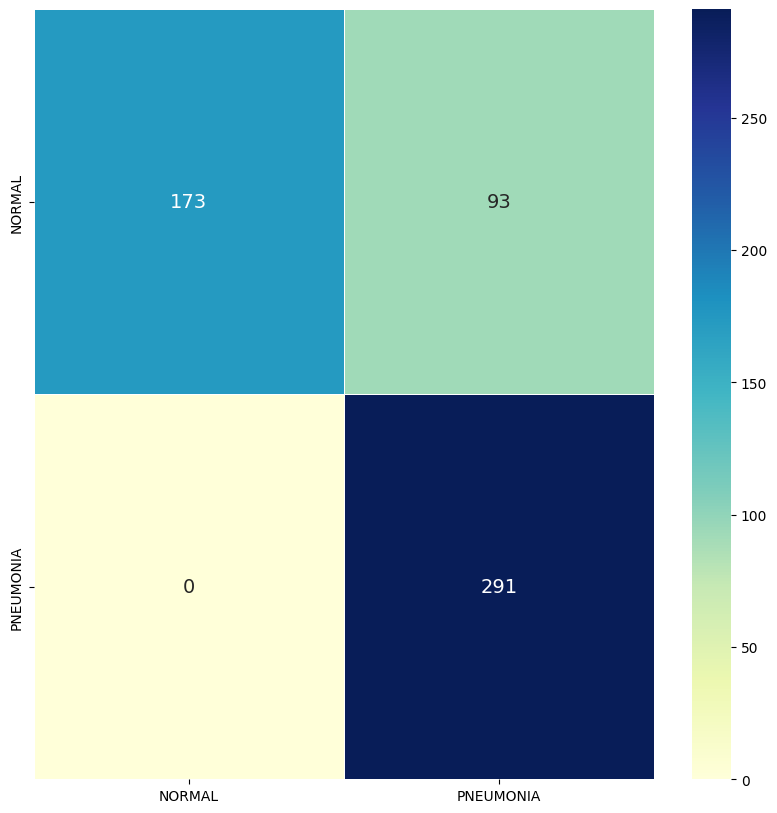

In [127]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [128]:
reporte = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
print(reporte)

nend = datetime.now()
print( nend - nstar)

              precision    recall  f1-score   support

      NORMAL       1.00      0.65      0.79       266
   PNEUMONIA       0.76      1.00      0.86       291

    accuracy                           0.83       557
   macro avg       0.88      0.83      0.83       557
weighted avg       0.87      0.83      0.83       557

0:15:29.588391


In [129]:
x_model.summary()
x_model.save("model_X.h5")
x_model.save_weights('pesos_X.h5')

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_6[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## CON FILTRO

In [130]:
x_custom_model.fit(x2_train, y2_train, batch_size=128, epochs=20, verbose=1, validation_data=(x2_test, y2_test))

Epoch 1/20
18/18 [==============================] - 46s 3s/step - loss: 0.0092 - accuracy: 0.9964 - val_loss: 4.1912 - val_accuracy: 0.5691
Epoch 2/20
18/18 [==============================] - 45s 2s/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 2.3413 - val_accuracy: 0.6840
Epoch 3/20
18/18 [==============================] - 46s 3s/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 2.7026 - val_accuracy: 0.6320
Epoch 4/20
18/18 [==============================] - 46s 3s/step - loss: 0.0035 - accuracy: 0.9987 - val_loss: 1.7743 - val_accuracy: 0.6894
Epoch 5/20
18/18 [==============================] - 45s 3s/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 1.5763 - val_accuracy: 0.7558
Epoch 6/20
18/18 [==============================] - 46s 3s/step - loss: 0.0051 - accuracy: 0.9982 - val_loss: 3.0849 - val_accuracy: 0.6409
Epoch 7/20
18/18 [==============================] - 46s 3s/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 2.5734 - val_accuracy: 0.6499
Epoch 8/20
18/18 [==

In [131]:
loss, acc = x_custom_model.evaluate(x2_test, y2_test, verbose=0)

In [132]:
print(loss, acc)

0.07979867607355118 0.9784560203552246


In [133]:
y2_pred = x_custom_model.predict(x2_test, verbose=1)
y2_pred = np.argmax(y2_pred, axis=1)

18/18 [==============================] - 3s 180ms/step


In [134]:
target_names = ['NORMAL', 'PNEUMONIA']

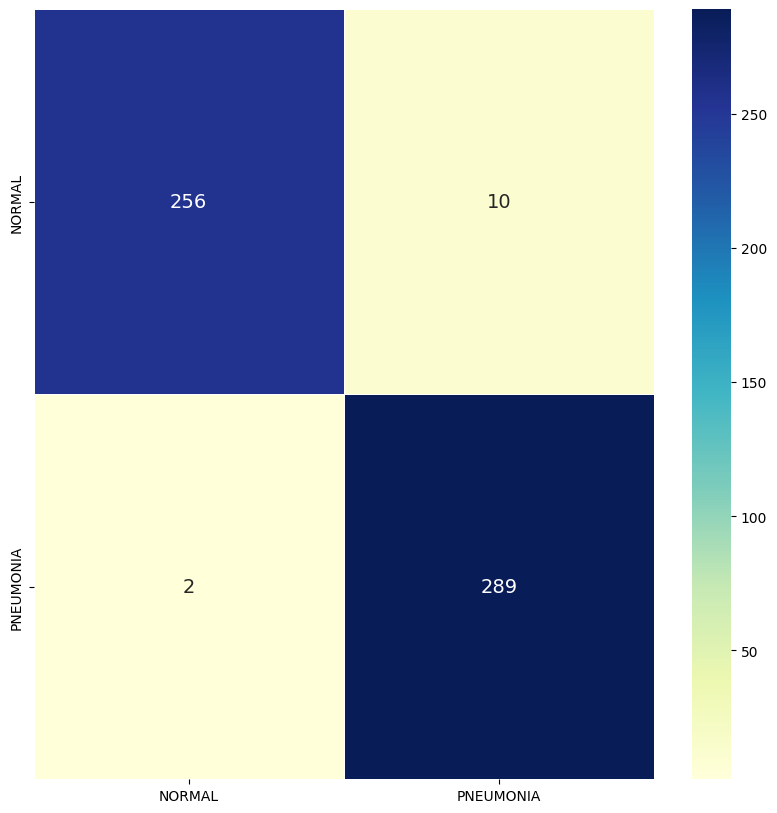

In [135]:
cm = confusion_matrix(np.argmax(y2_test, axis=1), y2_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [136]:
reporte = classification_report(np.argmax(y2_test, axis=1), y2_pred, target_names=target_names)
print(reporte)

nend = datetime.now()
print( nend - nstar)

              precision    recall  f1-score   support

      NORMAL       0.99      0.96      0.98       266
   PNEUMONIA       0.97      0.99      0.98       291

    accuracy                           0.98       557
   macro avg       0.98      0.98      0.98       557
weighted avg       0.98      0.98      0.98       557

0:30:51.208842


#Se almacena el segundo entrenamiento de Imagenet Xception

In [137]:
x_model.summary()
x_model.save("model_X2.h5")
x_model.save_weights('pesos_X2.h5')

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_6[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#0000000000000000000000000000000000000000000000000000

#implementando el modelo  de imagenet VGG16


In [138]:
nstar= datetime.now()
from tensorflow.keras.applications import VGG19


vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [139]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [140]:
for layer in vgg_model.layers[:19]:
    layer.trainable = False


for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_7 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [141]:
x = vgg_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [142]:
vgg_custom_model = Model(inputs=vgg_model.input, outputs=x)
vgg_custom_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [143]:
learning_rate= 1e-4
vgg_custom_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

## SIN FILTRO

In [144]:
vgg_custom_model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
18/18 [==============================] - 33s 2s/step - loss: 0.2887 - accuracy: 0.9060 - val_loss: 21.2449 - val_accuracy: 0.4776
Epoch 2/20
18/18 [==============================] - 31s 2s/step - loss: 0.0703 - accuracy: 0.9802 - val_loss: 3.0882 - val_accuracy: 0.6966
Epoch 3/20
18/18 [==============================] - 31s 2s/step - loss: 0.0601 - accuracy: 0.9753 - val_loss: 2.2391 - val_accuracy: 0.7020
Epoch 4/20
18/18 [==============================] - 31s 2s/step - loss: 0.0336 - accuracy: 0.9897 - val_loss: 0.3866 - val_accuracy: 0.9246
Epoch 5/20
18/18 [==============================] - 31s 2s/step - loss: 0.0171 - accuracy: 0.9928 - val_loss: 0.4564 - val_accuracy: 0.9246
Epoch 6/20
18/18 [==============================] - 31s 2s/step - loss: 0.0105 - accuracy: 0.9987 - val_loss: 1.1757 - val_accuracy: 0.8402
Epoch 7/20
18/18 [==============================] - 31s 2s/step - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.2483 - val_accuracy: 0.9551
Epoch 8/20
18/18 [=

In [145]:
loss, acc = vgg_custom_model.evaluate(x_test, y_test, verbose=0)

In [146]:
print(loss, acc)

0.46872884035110474 0.9389587044715881


In [147]:
y_pred = vgg_custom_model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

18/18 [==============================] - 5s 284ms/step


In [148]:
target_names = ['NORMAL', 'PNEUMONIA']

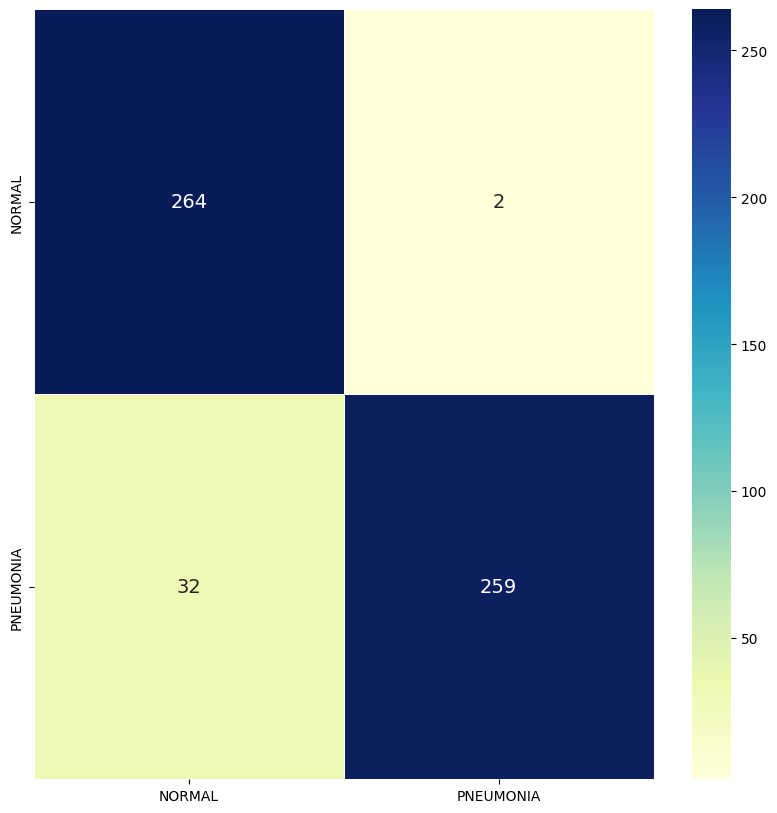

In [149]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [150]:
reporte = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
print(reporte)

nend = datetime.now()
print( nend - nstar)

              precision    recall  f1-score   support

      NORMAL       0.89      0.99      0.94       266
   PNEUMONIA       0.99      0.89      0.94       291

    accuracy                           0.94       557
   macro avg       0.94      0.94      0.94       557
weighted avg       0.94      0.94      0.94       557

0:10:34.218331


In [151]:
visualkeras.layered_view(vgg_custom_model, to_file='VGG.png', legend=False,).show()

In [152]:
vgg_custom_model.summary()
vgg_custom_model.save("model_VGG.h5")
vgg_custom_model.save_weights('pesos_VGG.h5')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88888888888888888888888888

## CON FILTRO

In [154]:
vgg_custom_model.fit(x2_train, y2_train, batch_size=128, epochs=20, verbose=1, validation_data=(x2_test, y2_test))

Epoch 1/20
18/18 [==============================] - 31s 2s/step - loss: 0.0419 - accuracy: 0.9847 - val_loss: 2.3323 - val_accuracy: 0.8133
Epoch 2/20
18/18 [==============================] - 31s 2s/step - loss: 0.0325 - accuracy: 0.9928 - val_loss: 1.7389 - val_accuracy: 0.8276
Epoch 3/20
18/18 [==============================] - 31s 2s/step - loss: 0.0176 - accuracy: 0.9928 - val_loss: 5.8105 - val_accuracy: 0.6840
Epoch 4/20
18/18 [==============================] - 31s 2s/step - loss: 0.0121 - accuracy: 0.9973 - val_loss: 0.6150 - val_accuracy: 0.9228
Epoch 5/20
18/18 [==============================] - 31s 2s/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 2.5586 - val_accuracy: 0.8061
Epoch 6/20
18/18 [==============================] - 31s 2s/step - loss: 0.0408 - accuracy: 0.9919 - val_loss: 0.8386 - val_accuracy: 0.9282
Epoch 7/20
18/18 [==============================] - 31s 2s/step - loss: 0.0128 - accuracy: 0.9964 - val_loss: 12.2467 - val_accuracy: 0.4811
Epoch 8/20
18/18 [=

In [155]:
loss, acc = vgg_custom_model.evaluate(x2_test, y2_test, verbose=0)

In [156]:
print(loss, acc)

0.28227418661117554 0.9622980356216431


In [157]:
y2_pred = vgg_custom_model.predict(x_test, verbose=1)
y2_pred = np.argmax(y2_pred, axis=1)

18/18 [==============================] - 5s 283ms/step


In [158]:
target_names = ['NORMAL', 'PNEUMONIA']

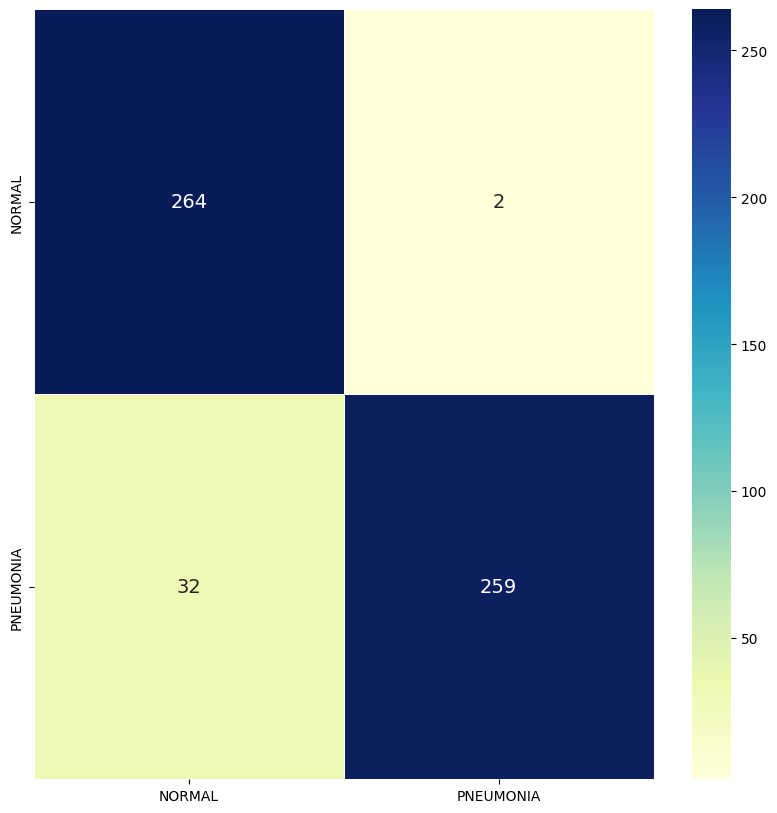

In [159]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [160]:
reporte = classification_report(np.argmax(y2_test, axis=1), y2_pred, target_names=target_names)
print(reporte)

nend = datetime.now()
print( nend - nstar)

              precision    recall  f1-score   support

      NORMAL       0.92      1.00      0.96       266
   PNEUMONIA       1.00      0.92      0.96       291

    accuracy                           0.96       557
   macro avg       0.96      0.96      0.96       557
weighted avg       0.96      0.96      0.96       557

0:32:10.249072


In [161]:
vgg_custom_model.summary()
vgg_custom_model.save("model_VGG2.h5")
vgg_custom_model.save_weights('pesos_VGG2.h5')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88888888888888888888888888

#implementando el modelo  de imagenet EfficientNetB7


In [162]:
nstar= datetime.now()
from tensorflow.keras.applications import EfficientNetB7


ef_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [163]:
ef_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_8[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1

In [164]:
for layer in ef_model.layers[:19]:
    layer.trainable = False

for i, layer in enumerate(ef_model.layers):
    print(i, layer.name, layer.trainable)

0 input_8 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block1c_dwconv True
31 block1c_bn True
32 block1c_activation True
33 block1c_se_squeeze True
34 block1c_se_reshape True
35 block1c_se_reduce True
36 block1c_se_expand True
37 block1c_se_excite True
38 block1c_project_conv True
39 block1c_project_bn True
40 block1c_drop Tru

In [165]:
x = ef_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax')(x)
ef_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_8[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1

In [166]:
ef_custom_model = Model(inputs=ef_model.input, outputs=x)
ef_custom_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_8[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1[0][0]'

In [167]:
learning_rate= 1e-4
ef_custom_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

## SIN FILTRO

In [168]:
ef_custom_model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
70/70 [==============================] - 315s 4s/step - loss: 2.2401 - accuracy: 0.8660 - val_loss: 165.9653 - val_accuracy: 0.5224
Epoch 2/20
70/70 [==============================] - 241s 3s/step - loss: 0.6379 - accuracy: 0.9029 - val_loss: 1.1213 - val_accuracy: 0.5224
Epoch 3/20
70/70 [==============================] - 238s 3s/step - loss: 6.4801 - accuracy: 0.8754 - val_loss: 2.6406 - val_accuracy: 0.4776
Epoch 4/20
70/70 [==============================] - 237s 3s/step - loss: 3.7578 - accuracy: 0.8566 - val_loss: 16.7896 - val_accuracy: 0.5619
Epoch 5/20
70/70 [==============================] - 239s 3s/step - loss: 0.5811 - accuracy: 0.8844 - val_loss: 4.8746 - val_accuracy: 0.6840
Epoch 6/20
70/70 [==============================] - 234s 3s/step - loss: 0.2550 - accuracy: 0.9186 - val_loss: 0.3491 - val_accuracy: 0.8456
Epoch 7/20
70/70 [==============================] - 233s 3s/step - loss: 0.1886 - accuracy: 0.9366 - val_loss: 0.2278 - val_accuracy: 0.9192
Epoch 8/20

In [169]:
loss, acc = ef_custom_model.evaluate(x_test, y_test, verbose=0)

In [170]:
print(loss, acc)

0.09490100294351578 0.9730700254440308


In [171]:
y_pred = ef_custom_model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

18/18 [==============================] - 16s 637ms/step


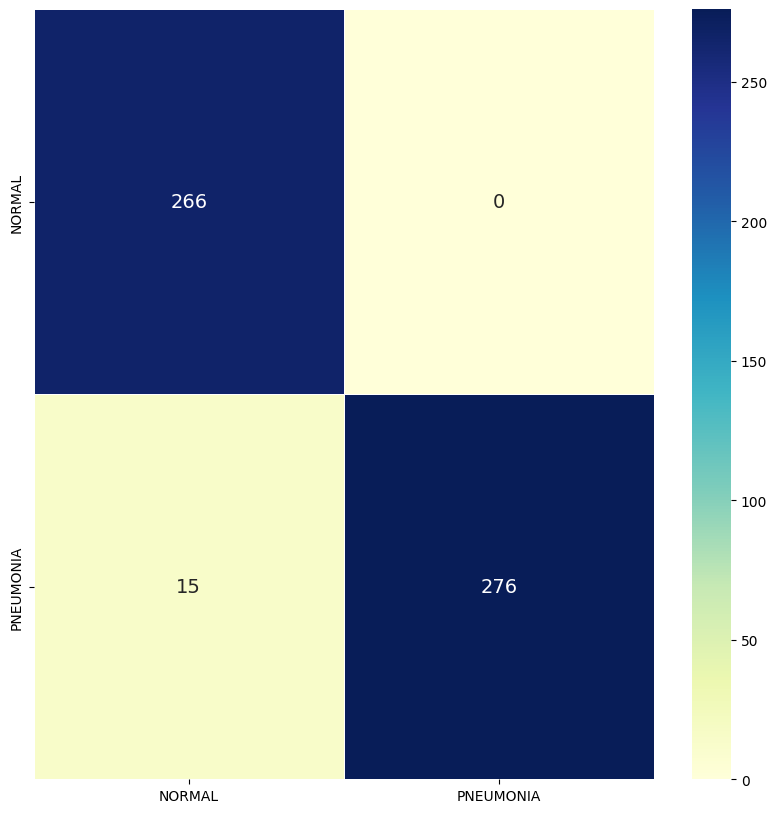

In [172]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [173]:
reporte = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
print(reporte)

nend = datetime.now()
print( nend - nstar)

              precision    recall  f1-score   support

      NORMAL       0.95      1.00      0.97       266
   PNEUMONIA       1.00      0.95      0.97       291

    accuracy                           0.97       557
   macro avg       0.97      0.97      0.97       557
weighted avg       0.97      0.97      0.97       557

1:20:37.414799


In [174]:
visualkeras.layered_view(ef_model, to_file='EfficientNetB7.png', legend=False,).show()

In [175]:
ef_model.summary()
ef_model.save("model_EF.h5")
ef_model.save_weights('pesos_EF.h5')

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_8[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7777777777777777777

## CON FILTRO

In [176]:
ef_custom_model.fit(x2_train, y2_train, batch_size=32, epochs=20, verbose=1, validation_data=(x2_test, y2_test))

Epoch 1/20
70/70 [==============================] - 236s 3s/step - loss: 0.0801 - accuracy: 0.9627 - val_loss: 0.3022 - val_accuracy: 0.8133
Epoch 2/20
70/70 [==============================] - 237s 3s/step - loss: 0.1668 - accuracy: 0.9474 - val_loss: 0.2570 - val_accuracy: 0.9443
Epoch 3/20
70/70 [==============================] - 235s 3s/step - loss: 0.2349 - accuracy: 0.9478 - val_loss: 0.1275 - val_accuracy: 0.9300
Epoch 4/20
70/70 [==============================] - 234s 3s/step - loss: 0.1387 - accuracy: 0.9357 - val_loss: 0.0715 - val_accuracy: 0.9713
Epoch 5/20
70/70 [==============================] - 232s 3s/step - loss: 0.1084 - accuracy: 0.9645 - val_loss: 0.1959 - val_accuracy: 0.9731
Epoch 6/20
70/70 [==============================] - 233s 3s/step - loss: 0.0758 - accuracy: 0.9681 - val_loss: 0.0789 - val_accuracy: 0.9767
Epoch 7/20
70/70 [==============================] - 226s 3s/step - loss: 0.0718 - accuracy: 0.9744 - val_loss: 0.1169 - val_accuracy: 0.9767
Epoch 8/20
70

In [177]:
loss, acc = ef_custom_model.evaluate(x2_test, y2_test, verbose=0)

In [178]:
print(loss, acc)

0.08747176080942154 0.9748653769493103


In [179]:
y2_pred = ef_custom_model.predict(x2_test, verbose=1)
y2_pred = np.argmax(y2_pred, axis=1)

18/18 [==============================] - 11s 616ms/step


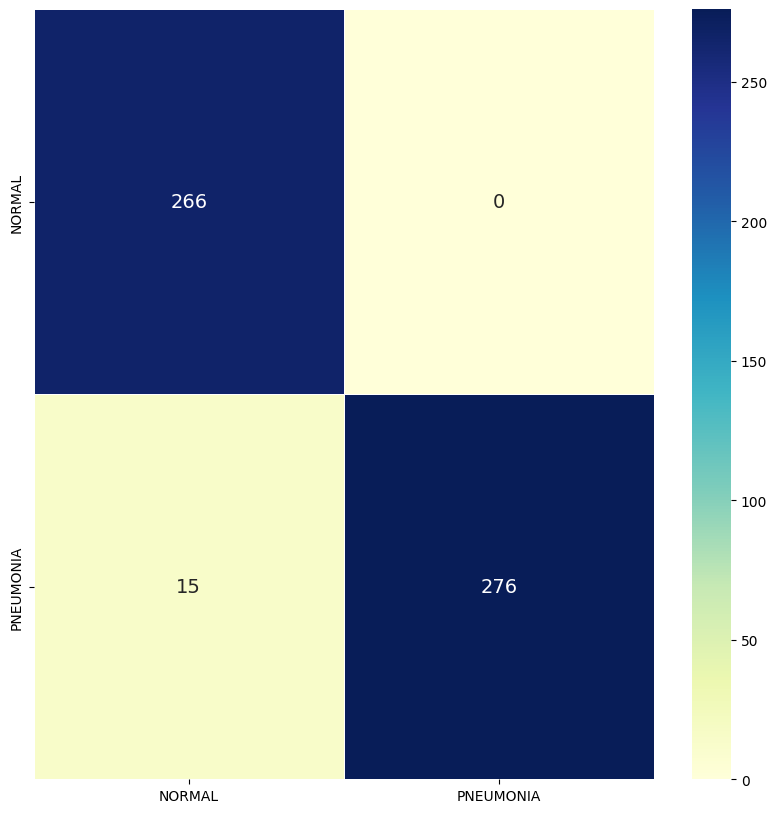

In [180]:
cm = confusion_matrix(np.argmax(y2_test, axis=1), y2_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [181]:
reporte = classification_report(np.argmax(y2_test, axis=1), y2_pred, target_names=target_names)
print(reporte)

nend = datetime.now()
print( nend - nstar)

              precision    recall  f1-score   support

      NORMAL       0.96      0.99      0.97       266
   PNEUMONIA       0.99      0.96      0.98       291

    accuracy                           0.97       557
   macro avg       0.97      0.98      0.97       557
weighted avg       0.98      0.97      0.97       557

2:38:04.245020


In [182]:
ef_model.summary()
ef_model.save("model_EF2.h5")
ef_model.save_weights('pesos_EF2.h5')

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_8[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7777777777777777777

#implementando el modelo  de imagenet ResNet50V2


In [183]:
nstar= datetime.now()
from tensorflow.keras.applications import ResNet50V2


rn_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [184]:
rn_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [185]:
for layer in rn_model.layers[:19]:
    layer.trainable = False

for i, layer in enumerate(rn_model.layers):
    print(i, layer.name, layer.trainable)

0 input_9 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_pad True
23 conv2_block2_2_conv True
24 conv2_block2_2_bn True
25 conv2_block2_2_relu True
26 conv2_block2_3_conv True
27 conv2_block2_out True
28 conv2_block3_preact_bn True
29 conv2_block3_preact_relu True
30 conv2_block3_1_conv True
31 conv2_block3_1_bn True
32 conv2_block3_1_relu True
33 conv2_block3_2_pad True
34 conv2_block3_2_conv True
35 conv2_block3_2_bn True
36 conv2_block3_2_relu True
37

In [186]:
x = rn_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax')(x)
rn_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [187]:
rn_custom_model = Model(inputs=rn_model.input, outputs=x)
rn_custom_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

In [188]:
learning_rate= 1e-4
rn_custom_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

## SIN FILTRO

In [189]:
rn_custom_model.fit(x_train, y_train, batch_size=64, epochs=20, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
35/35 [==============================] - 60s 1s/step - loss: 0.3164 - accuracy: 0.9222 - val_loss: 23.0277 - val_accuracy: 0.6248
Epoch 2/20
35/35 [==============================] - 47s 1s/step - loss: 0.1206 - accuracy: 0.9685 - val_loss: 78.8223 - val_accuracy: 0.5404
Epoch 3/20
35/35 [==============================] - 47s 1s/step - loss: 0.0767 - accuracy: 0.9757 - val_loss: 11.8752 - val_accuracy: 0.7253
Epoch 4/20
35/35 [==============================] - 47s 1s/step - loss: 0.0461 - accuracy: 0.9838 - val_loss: 3.6588 - val_accuracy: 0.8510
Epoch 5/20
35/35 [==============================] - 47s 1s/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.8019 - val_accuracy: 0.9192
Epoch 6/20
35/35 [==============================] - 47s 1s/step - loss: 0.0153 - accuracy: 0.9933 - val_loss: 0.1697 - val_accuracy: 0.9767
Epoch 7/20
35/35 [==============================] - 47s 1s/step - loss: 0.0089 - accuracy: 0.9982 - val_loss: 0.2593 - val_accuracy: 0.9695
Epoch 8/20
35/35 

In [190]:
loss, acc = rn_custom_model.evaluate(x_test, y_test, verbose=0)

In [191]:
print(loss, acc)

0.1489812433719635 0.9766606688499451


In [193]:
y_pred = rn_custom_model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

18/18 [==============================] - 3s 147ms/step


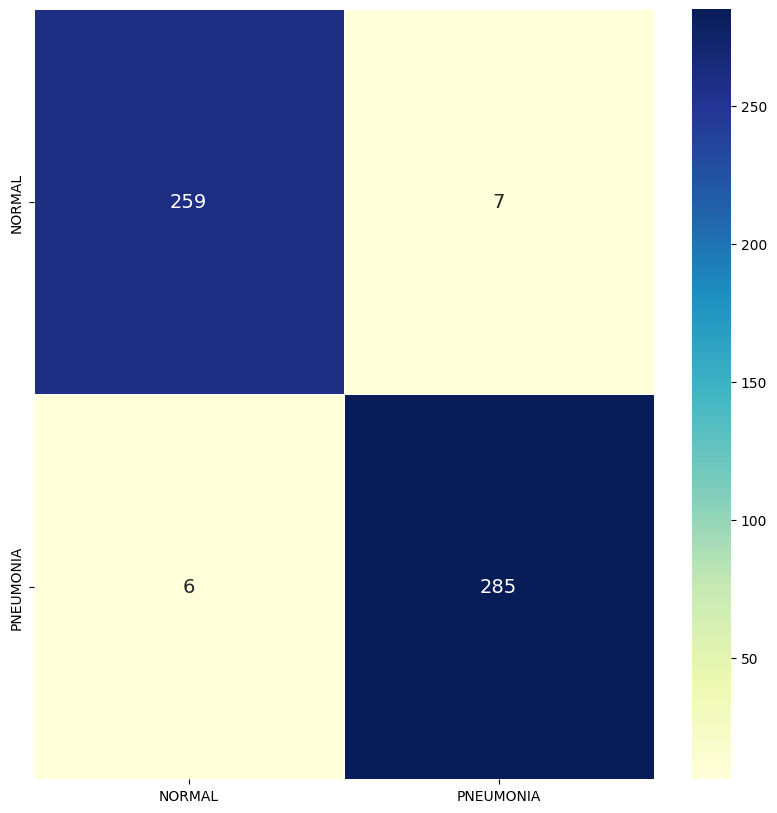

In [194]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [195]:
reporte = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
print(reporte)

nend = datetime.now()
print( nend - nstar)

              precision    recall  f1-score   support

      NORMAL       0.98      0.97      0.98       266
   PNEUMONIA       0.98      0.98      0.98       291

    accuracy                           0.98       557
   macro avg       0.98      0.98      0.98       557
weighted avg       0.98      0.98      0.98       557

1:10:21.811748


In [196]:
!pip install pillow==9.5.0
!pip install --upgrade visualkeras
import visualkeras
visualkeras.layered_view(rn_custom_model, to_file='ResNet50V2.png', legend=False).show()

In [197]:
rn_custom_model.summary()
rn_custom_model.save("model_RN.h5")
rn_custom_model.save_weights('pesos_RN.h5')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## CON FILTRO

In [198]:
rn_custom_model.fit(x2_train, y2_train, batch_size=64, epochs=20, verbose=1, validation_data=(x2_test, y2_test))

Epoch 1/20
35/35 [==============================] - 47s 1s/step - loss: 0.0426 - accuracy: 0.9856 - val_loss: 0.4545 - val_accuracy: 0.9605
Epoch 2/20
35/35 [==============================] - 47s 1s/step - loss: 0.0243 - accuracy: 0.9919 - val_loss: 0.2214 - val_accuracy: 0.9641
Epoch 3/20
35/35 [==============================] - 47s 1s/step - loss: 0.0467 - accuracy: 0.9883 - val_loss: 0.2211 - val_accuracy: 0.9677
Epoch 4/20
35/35 [==============================] - 47s 1s/step - loss: 0.0176 - accuracy: 0.9955 - val_loss: 0.3330 - val_accuracy: 0.9605
Epoch 5/20
35/35 [==============================] - 47s 1s/step - loss: 0.0225 - accuracy: 0.9933 - val_loss: 0.2564 - val_accuracy: 0.9425
Epoch 6/20
35/35 [==============================] - 47s 1s/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.6662 - val_accuracy: 0.8959
Epoch 7/20
35/35 [==============================] - 47s 1s/step - loss: 0.0214 - accuracy: 0.9919 - val_loss: 0.7308 - val_accuracy: 0.9264
Epoch 8/20
35/35 [==

In [199]:
loss, acc = rn_custom_model.evaluate(x2_test, y2_test, verbose=0)

In [200]:
print(loss, acc)

0.22652438282966614 0.9407540559768677


In [202]:
y2_pred = rn_custom_model.predict(x2_test, verbose=1)
y2_pred = np.argmax(y2_pred, axis=1)

18/18 [==============================] - 3s 148ms/step


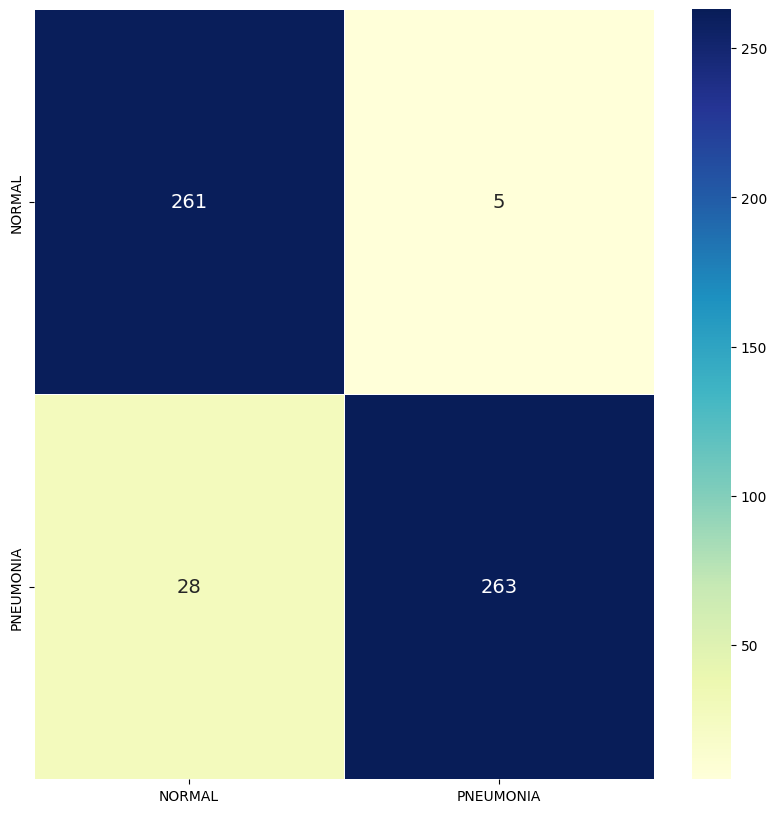

In [203]:
cm = confusion_matrix(np.argmax(y2_test, axis=1), y2_pred)
cm = pd.DataFrame(cm,  range(2),range(2))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 14},fmt="d",linewidths=.5,xticklabels=target_names, yticklabels=target_names,cmap="YlGnBu" ) # font size
plt.show()

In [204]:
reporte = classification_report(np.argmax(y2_test, axis=1), y2_pred, target_names=target_names)
print(reporte)

nend = datetime.now()
print( nend - nstar)

              precision    recall  f1-score   support

      NORMAL       0.90      0.98      0.94       266
   PNEUMONIA       0.98      0.90      0.94       291

    accuracy                           0.94       557
   macro avg       0.94      0.94      0.94       557
weighted avg       0.94      0.94      0.94       557

2:56:35.463630


In [205]:
rn_custom_model.summary()
rn_custom_model.save("model_RN2.h5")
rn_custom_model.save_weights('pesos_RN2.h5')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
